In [1]:
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import numpy as jnp
from jax import random
from numpyro import handlers, util
from numpyro.contrib.control_flow import scan
from numpyro.contrib.funsor import config_enumerate
from numpyro.infer import MCMC, NUTS, SVI, Predictive, TraceEnum_ELBO, autoguide
from numpyro.optim import Adam

rng_gen, rng_mcmc, rng_svi = random.split(random.PRNGKey(0), 3)

NT = 50
NS = 3
NZ = 2

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
prior = {
    "mu_loc": jnp.linspace(0.0, 15.0, NS),
    "mu_scale": jnp.ones(NS),
    "trans_s": jnp.eye(NS) + 0.2,
    "trans_z": jnp.eye(NZ) + 0.2,
    "conc": 3.0,
    "sigma_loc": jnp.array([1e-2, 1e-1]),
    "init_s": jnp.ones(NS) / NS,
    "init_z": jnp.ones(NZ) / NZ,
}

In [3]:
@config_enumerate
def model_scan(prior, obs=None, n=NT):
    nt = n if obs is None else len(obs)

    with numpyro.plate("s_space", NS, dim=-1):
        mu = numpyro.sample("mu", dist.Normal(prior["mu_loc"], prior["mu_scale"]))

    with numpyro.plate("z_space", NZ, dim=-1):
        sigma = numpyro.sample("sigma", dist.Exponential(prior["sigma_loc"]))

    trans_s = numpyro.sample(
        "trans_s", dist.Dirichlet(prior["trans_s"] * prior["conc"]).to_event(1)
    )
    trans_z = numpyro.sample(
        "trans_z", dist.Dirichlet(prior["trans_z"] * prior["conc"]).to_event(1)
    )
    s_m1 = numpyro.sample(
        "s_-1",
        dist.Categorical(prior["init_s"]),
    )
    z_m1 = numpyro.sample(
        "z_-1",
        dist.Categorical(prior["init_z"]),
    )
    init_state = (s_m1, z_m1)

    def transition(state, y_obs):
        s_prev, z_prev = state
        y = numpyro.sample("y", dist.Normal(mu[s_prev], sigma[z_prev]), obs=y_obs)
        s = numpyro.sample("s", dist.Categorical(trans_s[s_prev]))
        z = numpyro.sample("z", dist.Categorical(trans_z[z_prev]))
        return (s, z), (s, z, y)

    _, (s, z, y) = scan(transition, init_state, obs, length=nt)
    return (s, z, y)

# Generate data

In [4]:
gt = {"mu": jnp.array([-3, 1, 5]), "sigma": jnp.array([0.1, 2.0])}
samples = Predictive(handlers.condition(model_scan, gt), num_samples=1, parallel=True)(
    rng_gen, prior
)

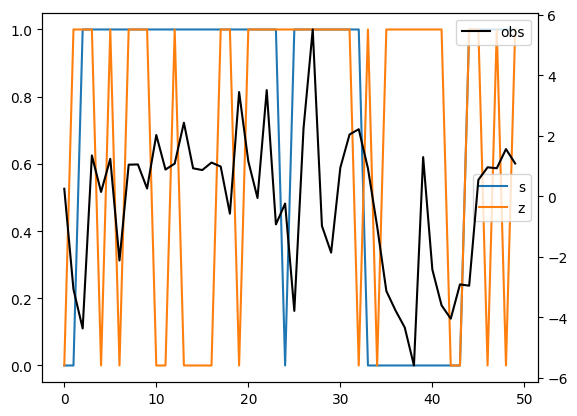

In [5]:
for label in ["s", "z"]:
    plt.plot(samples[label][0], label=label)
plt.legend()
plt.twinx().plot(samples["y"][0], label="obs", c="k")
plt.legend()
plt.show()

In [6]:
gt.update({k: v[0] for k, v in samples.items()})

In [7]:
with handlers.seed(rng_seed=0):
    trace = handlers.trace(model_scan).get_trace(prior, obs=gt["y"])
print(util.format_shapes(trace))

Trace Shapes:         
 Param Sites:         
Sample Sites:         
s_space plate  3 |    
      mu dist  3 |    
        value  3 |    
z_space plate  2 |    
   sigma dist  2 |    
        value  2 |    
 trans_s dist    | 3 3
        value    | 3 3
 trans_z dist    | 2 2
        value    | 2 2
    s_-1 dist    |    
        value    |    
    z_-1 dist    |    
        value    |    
       y dist 50 |    
        value 50 |    
       s dist 50 |    
        value 50 |    
       z dist 50 |    
        value 50 |    


# Learn model's continuous parameters with NUTS + enumeration

In [8]:
kernel = NUTS(model_scan)
mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=500,
)
mcmc.run(rng_mcmc, prior=prior, obs=gt["y"])
mcmc.print_summary()

TypeError: reshape total size must be unchanged, got new_sizes (49, 3) for shape (49, 2, 3, 1, 1, 1).

# Any luck with TraceEnum_ELBO?

In [9]:
guide_global = autoguide.AutoDelta(
    handlers.block(
        handlers.seed(model_scan, rng_seed=0),
        hide=["s_-1", "z_-1", "s", "z"],
    )
)

In [10]:
svi = SVI(
    model_scan,
    guide_global,
    Adam(1e-3),
    TraceEnum_ELBO(max_plate_nesting=1),
)
result = svi.run(rng_svi, num_steps=10_000, prior=prior, obs=gt["y"])

  0%|      | 0/10000 [00:00<?, ?it/s]


TypeError: reshape total size must be unchanged, got new_sizes (49, 3) for shape (49, 2, 3, 1, 1, 1).